In [1]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, leaves_list
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import MDS
from matplotlib.colors import BoundaryNorm

from model import LDM

In [2]:
class create_plots:
    def __init__(self, Aij, links, drug_emb, effect_emb, dim_reduction = "defualt", seed = None):
        self.Aij = Aij.detach().cpu().numpy()
        self.links = links.detach().cpu().numpy()
        self.drug_emb = drug_emb.detach().cpu().numpy()
        self.effect_emb = effect_emb.detach().cpu().numpy()
        self.dim_reduction = dim_reduction.lower()

        self.n_drugs = self.drug_emb.shape[0]
        self.n_effects = self.effect_emb.shape[0]

        self.seed = seed
        self.__set_seed(seed)

    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def create_network(self):
        G = nx.Graph()

        for i in range(self.n_drugs):
            G.add_node(f"Drug_{i}", bipartite=0)
        for j in range(self.n_effects):
            G.add_node(f"Effect_{j}", bipartite=1)

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                if self.links[i,j] != 0:  
                    G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=self.links[i,j])
        
        return G
    
    def reduce_dimensionality(self):
        """Reduce dimensionality using either the first two components or t-SNE."""
        if self.dim_reduction == "tsne":
            tsne = TSNE(n_components=2, perplexity=(self.n_drugs-1), random_state=self.seed)
            drugs_2d = tsne.fit_transform(self.drug_emb)
            effects_2d = tsne.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "MDS":
            mds = MDS(n_components=2, random_state=self.seed)
            # drugs_2d = mds.fit_transform(self.drug_emb)
            # effects_2d = mds.fit_transform(self.effect_emb)
            all_emb = np.vstack([self.drug_emb, self.effect_emb])
            
            # Apply MDS to combined data
            all_2d = mds.fit_transform(all_emb)
            
            # Split the reduced embeddings
            n_drugs = self.drug_emb.shape[0]
            drugs_2d = all_2d[:n_drugs]
            effects_2d = all_2d[n_drugs:]
            return drugs_2d, effects_2d

        
        elif self.dim_reduction == "pca":
            pca = PCA(n_components=2)
            drugs_2d = pca.fit_transform(self.drug_emb)
            effects_2d = pca.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "default":
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
        else: 
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
    
    def tsne_plot(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()

        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')
        drug_clusters = fcluster(drug_linkage, t=4, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=4, criterion='maxclust')
        
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        plt.figure(figsize=(10, 6))
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", color='blue', alpha=0.6)
        plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", color='red', alpha=0.6)

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.show()
        return drugs_2d, effects_2d
    


    def tsne_plot2(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # Perform hierarchical clustering
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        # Assign clusters
        drug_clusters = fcluster(drug_linkage, t=4, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=4, criterion='maxclust')

        # Assign colors by cluster
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        plt.figure(figsize=(10, 6))

        # Use cluster-based colors instead of fixed colors
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", c=drug_colors, alpha=0.6, edgecolor='k')
        #plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", c=effect_colors, alpha=0.6, marker='^', edgecolor='k')

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.xlim(1e-6*2.025, 1e-6*2.1)
        plt.ylim(1e-7*4.05, 1e-7*4.65)
        plt.grid(True)
        plt.show()

        return drugs_2d, effects_2d

    def tsne_plot2(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # Perform hierarchical clustering
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        # Assign clusters
        drug_clusters = fcluster(drug_linkage, t=9, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=5, criterion='maxclust')

        # Assign colors by cluster
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        plt.figure(figsize=(20, 15))

        # Use cluster-based colors instead of fixed colors
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", c=drug_colors)
        #plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", c=effect_colors, alpha=0.6, marker='^', edgecolor='k')

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.xlim(1e-6*2.025, 1e-6*2.1)
        plt.ylim(1e-7*4, 1e-7*4.7)
        plt.grid(True)
        plt.show()

        return drugs_2d, effects_2d


    def links_space_clustered(self):
        G = self.create_network()
        # drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # # Dendrogram clustering for coloring
        # drug_linkage = linkage(self.drug_emb, method='ward')
        # effect_linkage = linkage(self.effect_emb, method='ward')
        # drug_clusters = fcluster(drug_linkage, t=9, criterion='maxclust')
        # effect_clusters = fcluster(effect_linkage, t=9, criterion='maxclust')
        
        # drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        # effect_colors = [cm.Set2(i % 8) for i in effect_clusters]
        # Stack embeddings
        drugs_2d, effects_2d = self.reduce_dimensionality()
        all_emb = np.vstack([drugs_2d, effects_2d])

        # Unified clustering
        linkage_all = linkage(all_emb, method='ward')
        clusters = fcluster(linkage_all, t=9, criterion='maxclust')

        # Split embeddings
        n_drugs = self.n_drugs
        drug_clusters = clusters[:n_drugs]
        effect_clusters = clusters[n_drugs:]
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]
        # Positions
        pos = {}
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drugs_2d[i, 0], drugs_2d[i, 1])
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effects_2d[j, 0], effects_2d[j, 1])

        # Assign cluster-based node colors
        node_colors = []
        for node in G.nodes:
            if "Drug" in node:
                idx = int(node.split("_")[1])
                node_colors.append(drug_colors[idx])
            else:
                idx = int(node.split("_")[1])
                node_colors.append(effect_colors[idx])

        # Plot
        plt.figure(figsize=(12, 12))
        nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors,
                font_size=10, font_weight='bold', edge_color='gray')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

        plt.title('Drug-Side Effect Network Colored by Dendrogram Clusters')
        plt.show()

    def links_space_both(self):
        # Stack embeddings
        drugs_2d, effects_2d = self.reduce_dimensionality()
        all_emb = np.vstack([drugs_2d, effects_2d])

        # Unified clustering
        linkage_all = linkage(all_emb, method='ward')
        clusters = fcluster(linkage_all, t=9, criterion='maxclust')

        # Split embeddings
        n_drugs = self.n_drugs
        drug_clusters = clusters[:n_drugs]
        effect_clusters = clusters[n_drugs:]

        # Plot with distinct markers and transparency
        n_clusters = np.max(clusters)
        cmap = cm.get_cmap('tab20', n_clusters +1)
        coloring = {i: cmap(i) for i in range(1, n_clusters+1)}
        drug_colorings = {i: cmap(2 * i - 1) for i in range(1, n_clusters+1)}
        effect_colorings ={i: cmap(2 * (i - 1)) for i in range(1, n_clusters+1)}

        plt.figure(figsize=(10, 10))

        # Drugs, circles
        for i in range(1, np.max(clusters) + 1):
            mask = (drug_clusters == i)
            plt.scatter(drugs_2d[mask, 0], drugs_2d[mask, 1], 
                        color = coloring[i], label=f'Drug Cluster {i}', alpha=0.8, s=10)

        #Effects: triangles
        for i in range(1, np.max(clusters) + 1):
            mask = (effect_clusters == i)
            plt.scatter(effects_2d[mask, 0], effects_2d[mask, 1], 
                        color = coloring[i], label=f'Effect Cluster {i}', alpha=0.4, s=10)

        plt.legend(markerscale=2)
        plt.title("Embedding Space with Joint Clustering (Drugs and Side Effects)")
        plt.grid(False)
        plt.show()
    def links_space_effects(self):
        # Stack embeddings
        drugs_2d, effects_2d = self.reduce_dimensionality()
        all_emb = np.vstack([drugs_2d, effects_2d])

        # Unified clustering
        linkage_all = linkage(all_emb, method='ward')
        clusters = fcluster(linkage_all, t=9, criterion='maxclust')

        # Split embeddings
        n_drugs = self.n_drugs
        effect_clusters = clusters[n_drugs:]

        # Plot with distinct markers and transparency
        n_clusters = np.max(clusters)
        cmap = cm.get_cmap('tab10', n_clusters +1)
        coloring = {i: cmap(i) for i in range(1, n_clusters+1)}

        plt.figure(figsize=(10, 10))

        #Effects: triangles
        for i in range(1, np.max(clusters) + 1):
            mask = (effect_clusters == i)
            plt.scatter(effects_2d[mask, 0], effects_2d[mask, 1], 
                        color = coloring[i], label=f'Effect Cluster {i}', alpha=0.6, s=10)

        plt.legend(markerscale=2)
        plt.title("Embedding Space with Joint Clustering (Side Effects)")
        plt.grid(False)
        plt.show()

    def links_space_drugs(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        all_emb = np.vstack([drugs_2d, effects_2d])

        # Unified clustering
        linkage_all = linkage(all_emb, method='ward')
        clusters = fcluster(linkage_all, t=9, criterion='maxclust')

        # Split embeddings
        n_drugs = self.n_drugs
        drug_clusters = clusters[:n_drugs]
        effect_clusters = clusters[n_drugs:]

        #Make coloring
        n_clusters = np.max(clusters)
        cmap = cm.get_cmap('tab10', n_clusters +1)
        coloring = {i: cmap(i) for i in range(1, n_clusters+1)}

        plt.figure(figsize=(10, 10))

        # Draw drugs
        for i in range(1, np.max(clusters) + 1):
            mask = (drug_clusters == i)
            plt.scatter(drugs_2d[mask, 0], drugs_2d[mask, 1], 
                        color = coloring[i], label=f'Drug Cluster {i}', alpha=0.6, s=10)

        plt.legend(markerscale=2)
        plt.title("Embedding Space with Joint Clustering (Drugs)")
        plt.grid(False)
        plt.show()

    
    def simple_links(self):
        G = self.create_network()

        pos = {}
        pos.update((node, (1, index)) for index, node in enumerate(f"Drug_{i}" for i in range(self.n_drugs)))  # Position for drugs
        pos.update((node, (2, index)) for index, node in enumerate(f"Effect_{j}" for j in range(self.n_effects)))  # Position for effects

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=500, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (optional)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network')
        plt.show()

    def dendrograms_individual(self):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        plt.figure(figsize=(20, 10))
        dendrogram(drug_linkage, labels=[f"Drug {i}" for i in range(len(self.drug_emb))], leaf_rotation=90)
        plt.xlabel("Drugs")
        plt.ylabel("Distance")
        plt.title("Drug Hierarchical Clustering Dendrogram")
        plt.show()

        plt.figure(figsize=(20, 10))
        dendrogram(effect_linkage, labels=[f"SE {i}" for i in range(len(self.effect_emb))], leaf_rotation=90)
        plt.xlabel("Side Effects")
        plt.ylabel("Distance")
        plt.title("Side Effect Hierarchical Clustering Dendrogram")
        plt.show()

    def dendrograms_joint(self):
        all_emb = np.vstack([self.drug_emb, self.effect_emb])
        labels = [f"Drug {i}" for i in range(len(self.drug_emb))] + [f"SE {j}" for j in range(len(self.effect_emb))]
        linkage_all = linkage(all_emb, method='ward')

        plt.figure(figsize=(25, 10))
        dendrogram(linkage_all, labels=labels, leaf_rotation=90)
        plt.xlabel("Entities (Drugs + Side Effects)")
        plt.ylabel("Distance")
        plt.title("Joint Dendrogram (Drugs + Side Effects)")
        plt.tight_layout()
        plt.show()

    def reorder_matrix(self, t=9, criterion='maxclust'):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_link = linkage(self.drug_emb, method='ward')
        effect_link = linkage(self.effect_emb, method='ward')
        drug_linkage = fcluster(drug_link, t=t, criterion=criterion)
        effect_linkage = fcluster(effect_link, t=t, criterion=criterion)
        # Find new order
        # drug_order = leaves_list(drug_linkage)
        # effect_order = leaves_list(effect_linkage)
        drug_order = np.argsort(drug_linkage)
        effect_order = np.argsort(effect_linkage)
        Aij_reordered = self.Aij[drug_order, :][:, effect_order]

        drug_adj = self.Aij @ self.Aij.T  # Drug-drug adjacency
        effect_adj = self.Aij.T @ self.Aij  # Effect-effect adjacency

        drug_adj_reordered = drug_adj[drug_order, :][:, drug_order]
        effect_adj_reordered = effect_adj[effect_order, :][:, effect_order]
        return Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj
    
    def plot_reorder_Aij(self):
        Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj = self.reorder_matrix()
        print("Reordered Aij shape:", Aij_reordered.shape)
        print("Reordered Aij min/max:", Aij_reordered.min(), Aij_reordered.max())
        cmap = plt.cm.Oranges
        bounds = [0, 1, 2, 3, 4]
        norm = BoundaryNorm(bounds, cmap.N)
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(self.Aij, cmap=cmap, norm=norm, aspect='auto')
        plt.title("Original Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.imshow(Aij_reordered, cmap=cmap, norm=norm, aspect='auto')
        plt.title("Reordered Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    def plot_reorder_Aij_multi(self, t_values=[4, 6, 9, 12], criterion='maxclust'):
        cmap = plt.cm.Oranges
        bounds = [0, 1, 2, 3, 4]
        norm = BoundaryNorm(bounds, cmap.N)

        n_cols = len(t_values) + 1
        plt.figure(figsize=(5 * n_cols, 10))

        # Plot the original Aij first
        plt.subplot(1, n_cols, 1)
        plt.imshow(self.Aij, cmap=cmap, norm=norm, aspect='auto')
        plt.title("Original Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        # Loop over different t values
        for i, t in enumerate(t_values):
            Aij_reordered, _, _, _, _ = self.reorder_matrix(t=t, criterion=criterion)
            ax = plt.subplot(1, n_cols, i + 2)
            im = ax.imshow(Aij_reordered, cmap=cmap, norm=norm, aspect='auto')
            ax.set_title(f"Reordered Aij (t={t})")
            ax.set_xlabel("Side Effects")
            ax.set_ylabel("Drugs")
            plt.colorbar(im, ax=ax)

        plt.tight_layout()
        plt.show()


In [3]:
def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function During Training')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### real data

In [315]:

class LDMP(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=None):
        super(LDMP, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item() +1

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.gamma = nn.Parameter(torch.randn(1, device=device))
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    

    def get_thresholds(self):
        # Ensure thresholds remain positive and increasing
        deltas = torch.softmax(self.beta_thilde, dim = 0)  # Ensure positive increments
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def probit(self):
        # #n_ordinal_classes = len(self.thresholds) - 1
        # #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_ordinal_classes, self.n_drugs, self.n_effects), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = self.gamma + linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[y, :, :] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    
    def predict_categories(self):
        probit_matrix = self.probit()  # Call probit to get probabilities
        return torch.argmax(probit_matrix, dim=0), probit_matrix
    
    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        freqs = torch.tensor([2685824, 19987, 10354, 23200], dtype=torch.float32, device= self.device)
        class_weights = 1.0 / (freqs + 1e-6)  # Avoid div by 0
        class_weights = class_weights / class_weights.sum()
        probit_matrix = self.probit() 
        # Initialize loss variable
        loss = 0.0

        # Convert Aij to a one-hot encoded tensor
        one_hot_target = torch.zeros(self.n_drugs, self.n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, self.Aij.unsqueeze(-1).long(), 1)  # One-hot encoding

        # Compute the log-likelihood loss efficiently
        prob = probit_matrix  # Shape: (n_ordinal_classes, n_drugs, n_effects)
        # loss = -torch.sum(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        #loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        weighted_log_prob = torch.log(torch.sum(probit_matrix * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8)
        weighted_loss = -torch.sum(weighted_log_prob * (one_hot_target * class_weights.view(1, 1, -1)).sum(dim=2)) / (self.n_drugs * self.n_effects)
        return weighted_loss

    def train(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        #final_loss = None  # Store the last loss
        epoch_losses = []

        for epoch in range(self.n_epochs):
            optimizer.zero_grad()  # Reset gradients
            loss = self.ordinal_cross_entropy_loss()  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            #final_loss = loss.item()  # Store latest loss value
            #final_loss = loss.item()  # Store latest loss value
            epoch_losses.append(loss.item())
            print(f"Epoch {epoch}/{self.n_epochs}, Loss: {loss.item():.4f}")
        

        return epoch_losses #,final_loss

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        

In [4]:
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/LatentDistanceModel/data/filtered_adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([745, 3677])


In [8]:
embedding_dim = 15
n_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.01
seed = 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output, latent_var = model.probit()  # Compute the probit probability matrix
loss_out = model.train() 

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/200, Loss: 3.5310
Epoch 1/200, Loss: 3.1466
Epoch 2/200, Loss: 2.7981
Epoch 3/200, Loss: 2.4501
Epoch 4/200, Loss: 2.1753
Epoch 5/200, Loss: 1.9290
Epoch 6/200, Loss: 1.7561
Epoch 7/200, Loss: 1.5863
Epoch 8/200, Loss: 1.4130
Epoch 9/200, Loss: 1.2754
Epoch 10/200, Loss: 1.1588
Epoch 11/200, Loss: 1.0558
Epoch 12/200, Loss: 0.9664
Epoch 13/200, Loss: 0.9040
Epoch 14/200, Loss: 0.8458
Epoch 15/200, Loss: 0.7887
Epoch 16/200, Loss: 0.7384
Epoch 17/200, Loss: 0.6979
Epoch 18/200, Loss: 0.6663
Epoch 19/200, Loss: 0.6419
Epoch 20/200, Loss: 0.6231
Epoch 21/200, Loss: 0.6084
Epoch 22/200, Loss: 0.5961
Epoch 23/200, Loss: 0.5845
Epoch 24/200, Loss: 0.5728
Epoch 25/200, Loss: 0.5607
Epoch 26/200, Loss: 0.5486
Epoch 27/200, Loss: 0.5372
Epoch 28/200, Loss: 0.5267
Epoch 29/200, Loss: 0.5172
Epoch 30/200, Loss: 0.5087
Epoch 31/200, Loss: 0.5006
Epoch 32/200, Loss: 0.4924
Epoch 33/200, Loss: 0.4832
Epoch 34/200, Loss: 0.4739
Epoch 35/200, Loss: 0.4657
Epoch 36/200, Loss: 0.4590
Epoch 37/20

In [306]:
values, counts = torch.unique(Aij_real, return_counts=True)
print(dict(zip(values.tolist(), counts.tolist())))

{0.0: 2685824, 1.0: 19987, 2.0: 10354, 3.0: 23200}


In [374]:
torch.tensor(counts, dtype=torch.float32, device= device)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_6085/3271437458.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(counts, dtype=torch.float32, device= device)


tensor([2685824.,   19987.,   10354.,   23200.])

In [9]:
links, ordinal_vals = model.predict_categories()
drug_emb, effect_emb = model.get_embeddings()

In [318]:
num_different = (Aij_real != links).sum().item()
ratio = num_different/(Aij_real.shape[0]*Aij_real.shape[1])
print(f"Number of differing entries: {num_different}, ratio: {ratio}")

Number of differing entries: 265443, ratio: 0.09689946392685896


In [319]:
diff_mask = Aij_real != links
value_diff_counts = {}
for val in range(4):
    count = ((links == val) & diff_mask).sum().item()
    value_diff_counts[val] = count

print(value_diff_counts)

{0: 28218, 1: 174214, 2: 23631, 3: 39380}


In [320]:
unique_values = [0, 1, 2, 3]
for val in unique_values:
    count1 = (Aij_real == val).sum().item()
    count2 = (links == val).sum().item()
    print(f"Value {val}: tensor1 has {count1}, tensor2 has {count2}")

Value 0: tensor1 has 2685824, tensor2 has 2482249
Value 1: tensor1 has 19987, tensor2 has 183009
Value 2: tensor1 has 10354, tensor2 has 25290
Value 3: tensor1 has 23200, tensor2 has 48817


In [10]:
plots2 = create_plots(links, Aij_real, drug_emb, effect_emb, dim_reduction="MDS", seed = 10)

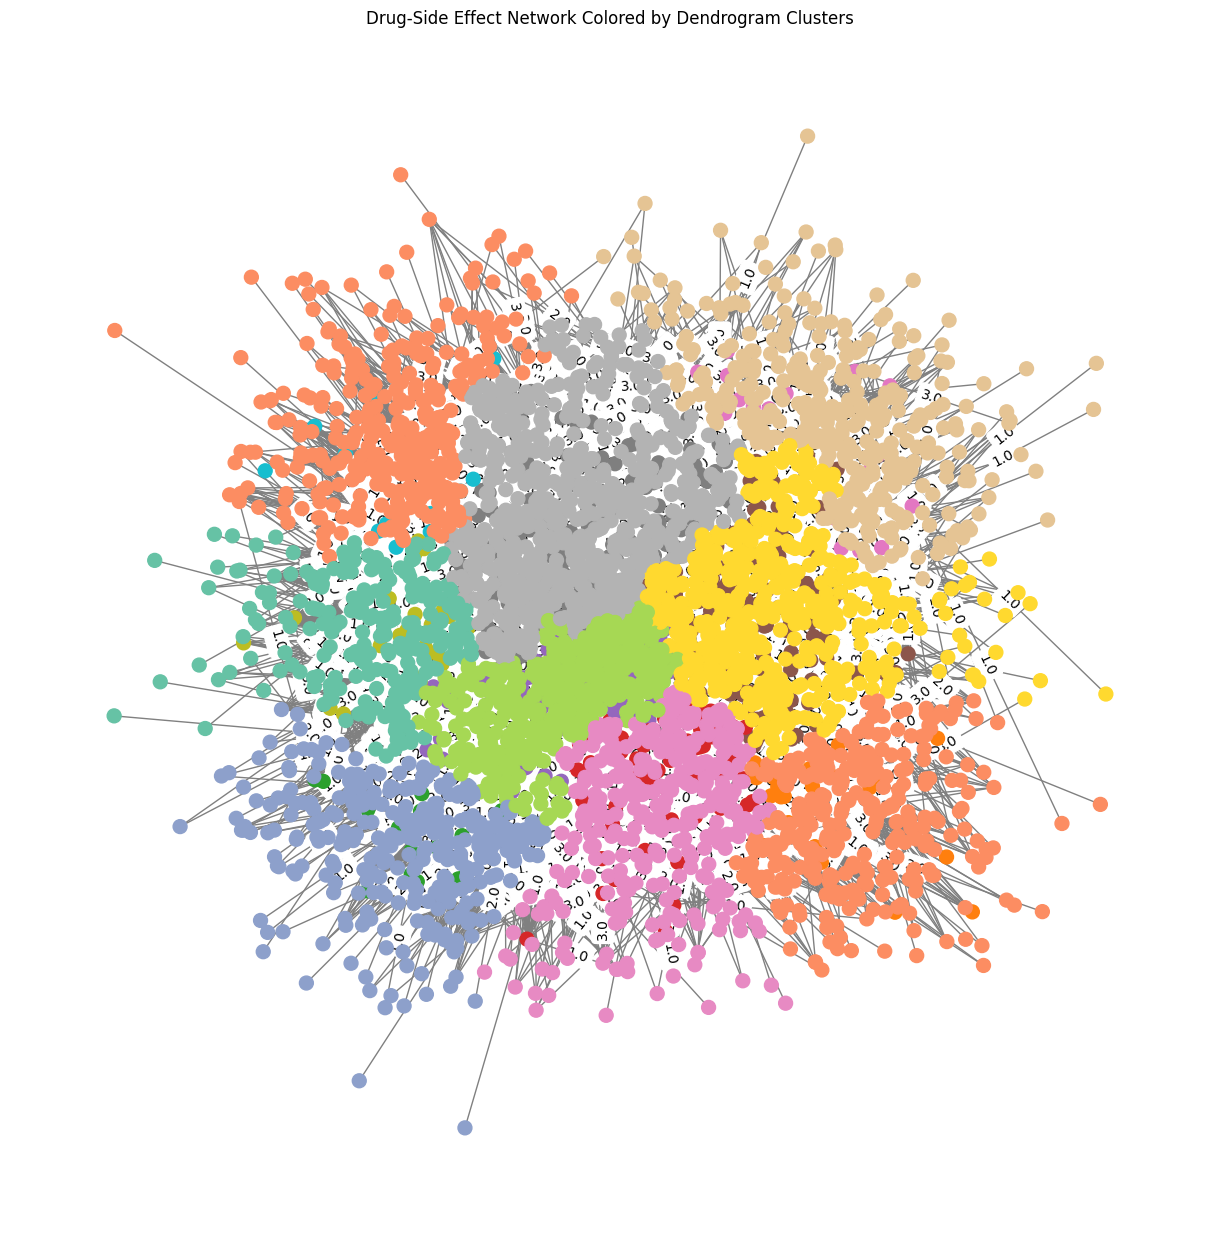

In [369]:
plots2.links_space_clustered()

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_98940/2768705631.py:302: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_clusters +1)


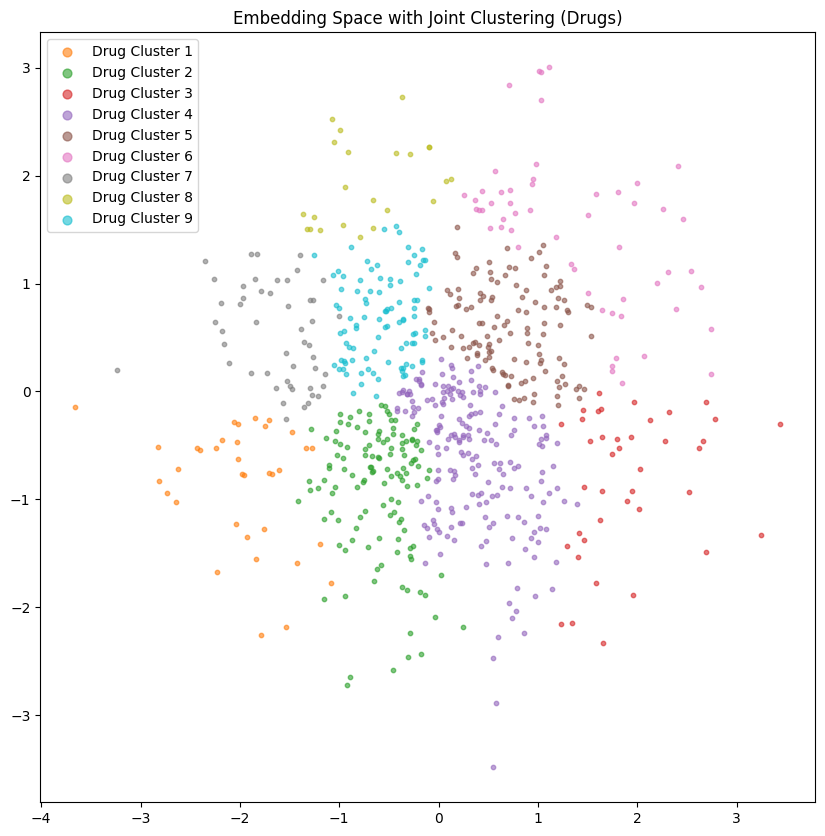

In [11]:
plots2.links_space_drugs()

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_98940/2768705631.py:271: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_clusters +1)


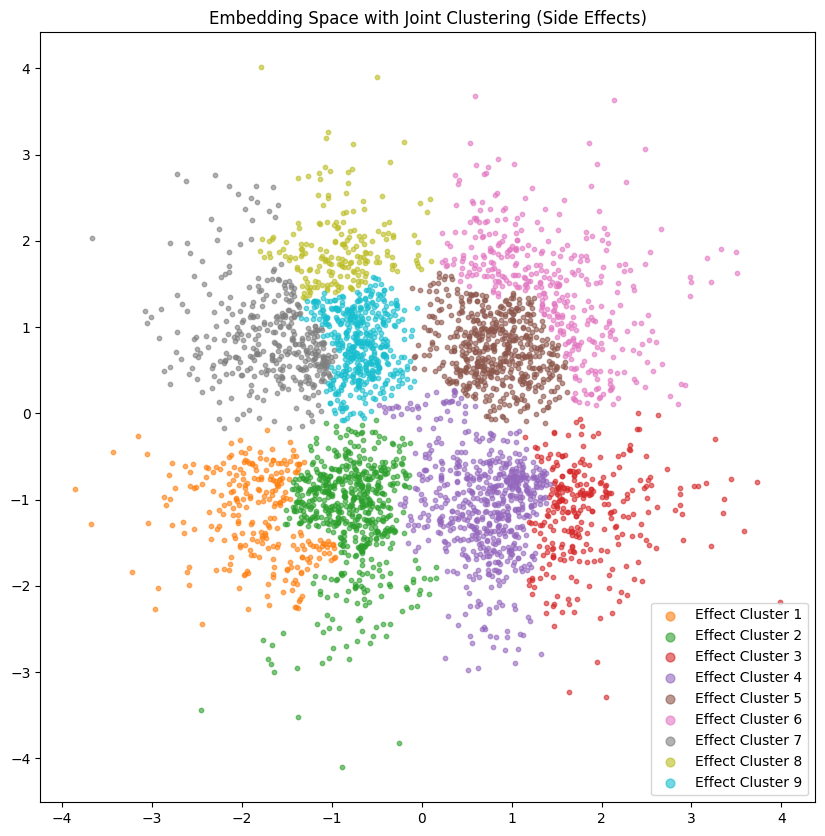

In [12]:
plots2.links_space_effects()

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_98940/2768705631.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_clusters +1)


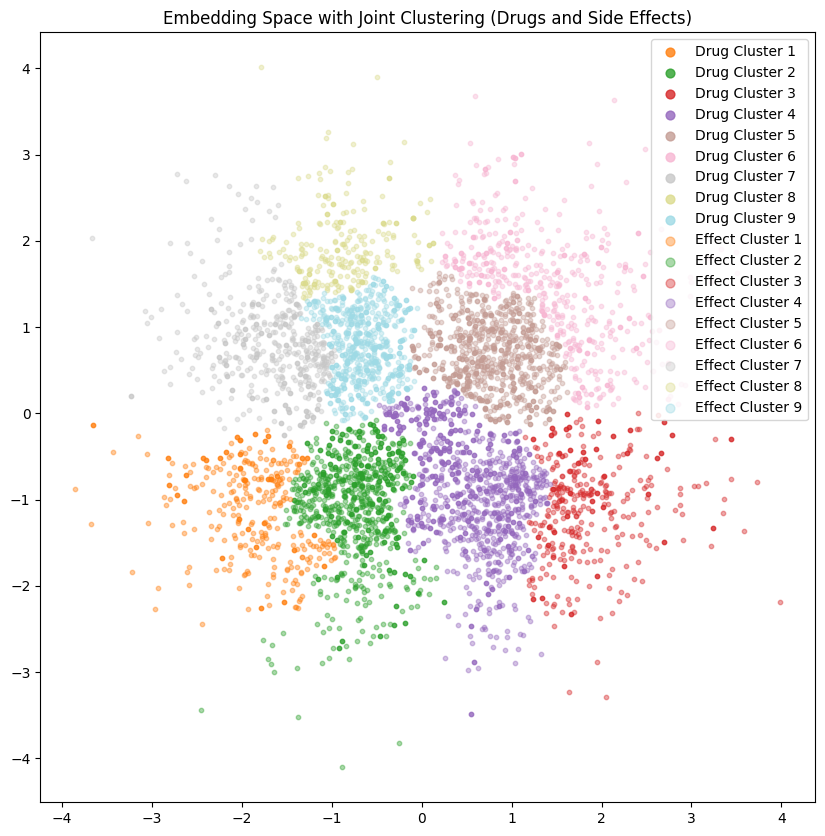

In [13]:
plots2.links_space_both()

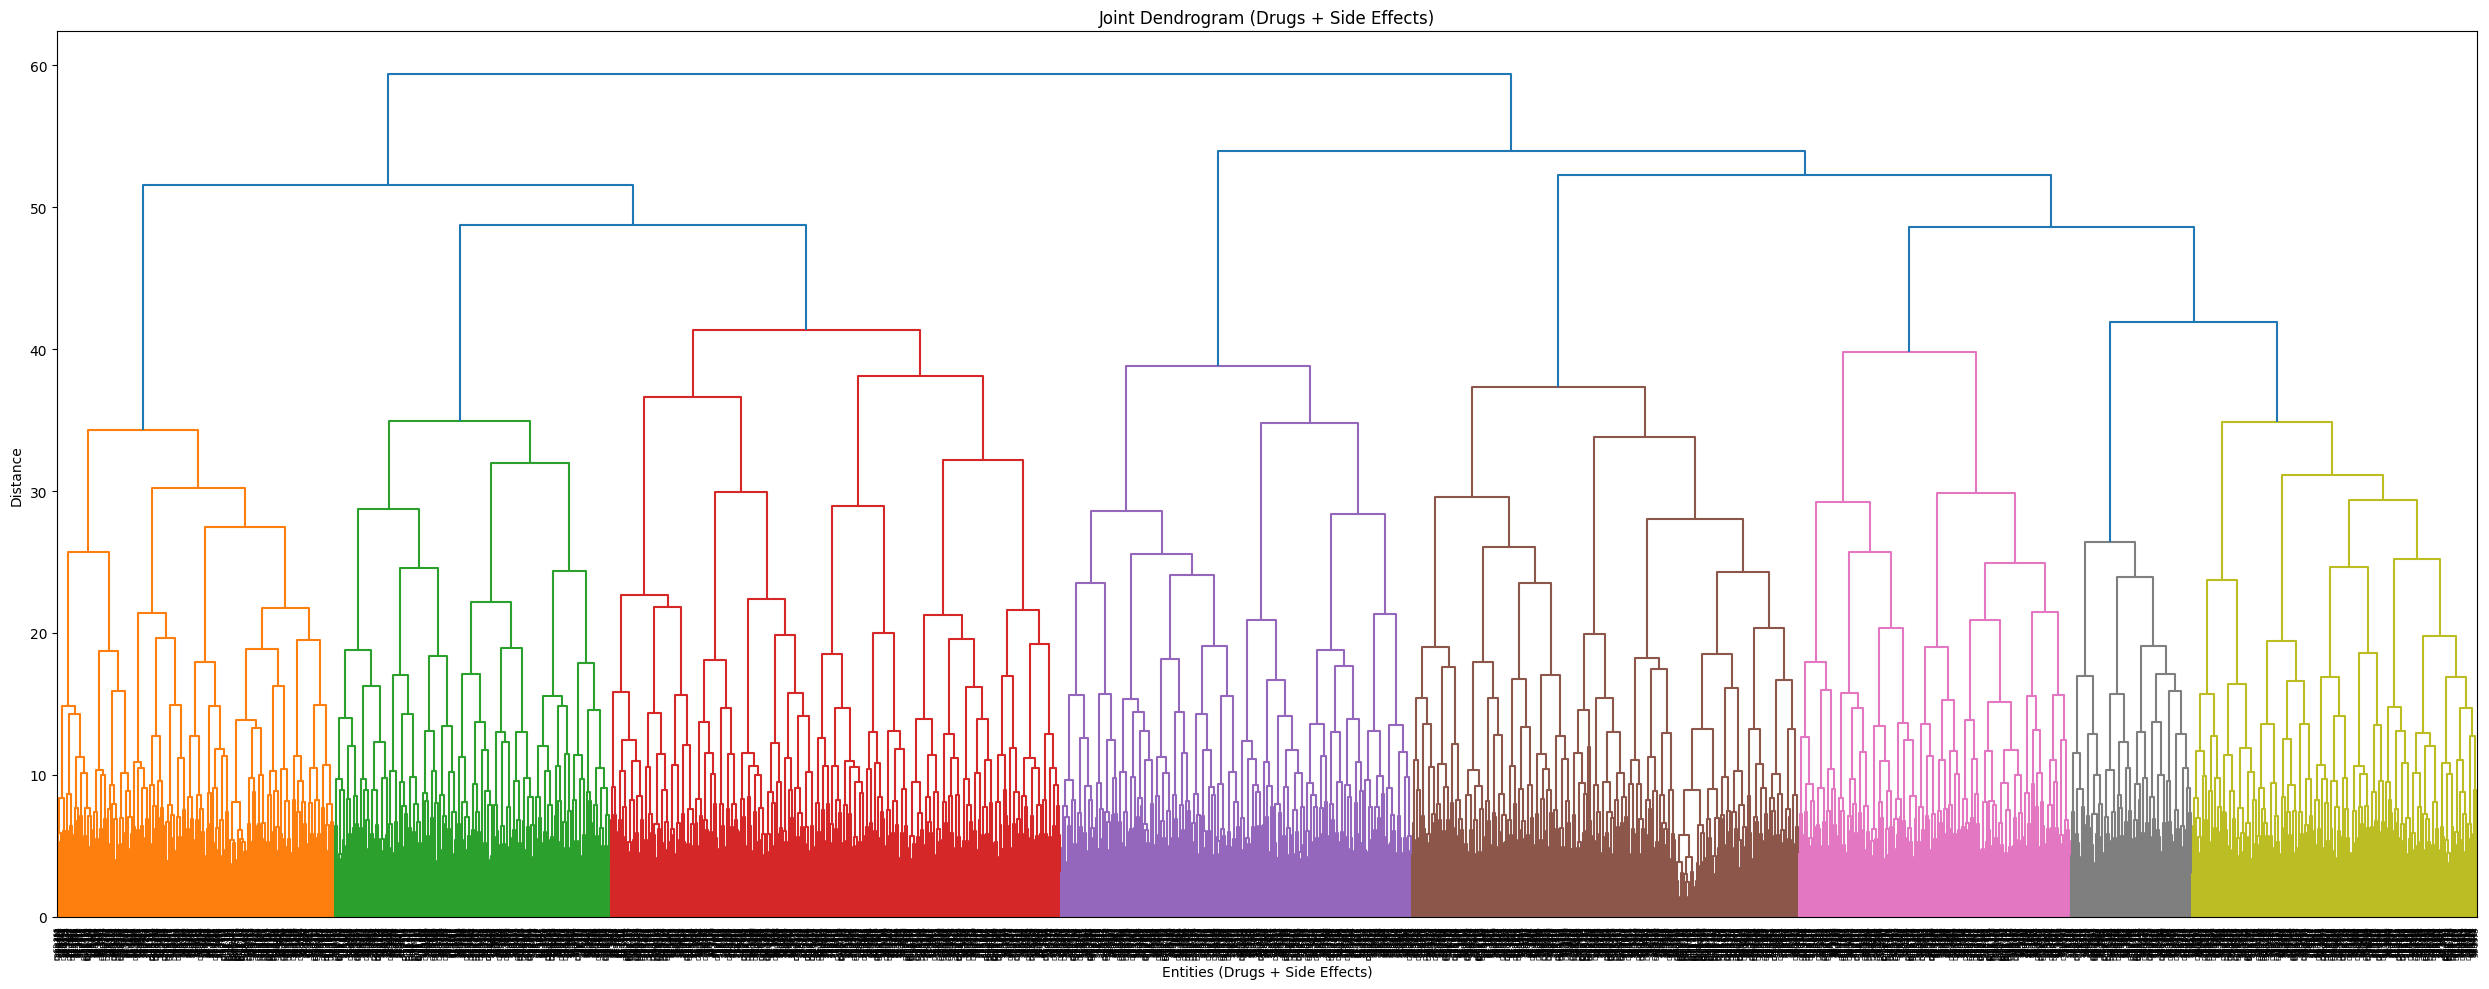

In [14]:
plots2.dendrograms_joint()

Reordered Aij shape: (745, 3677)
Reordered Aij min/max: 0 0


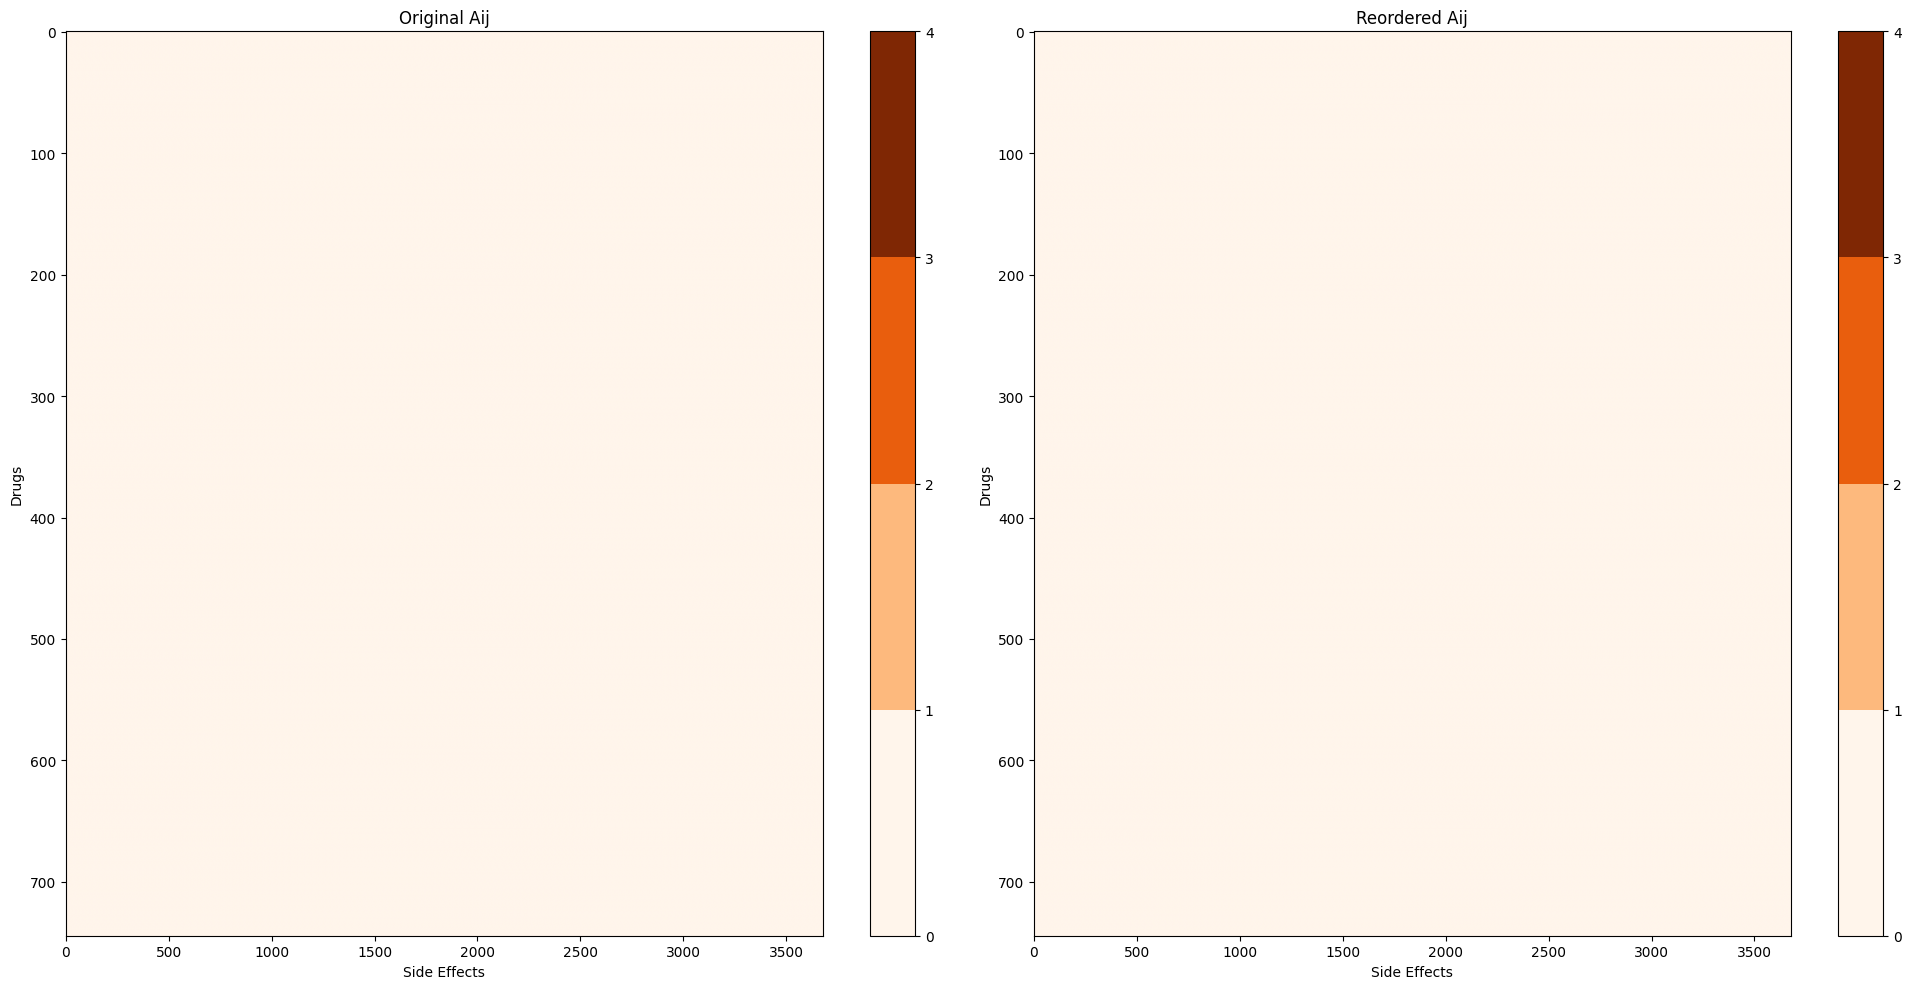

In [12]:
plots2.plot_reorder_Aij()

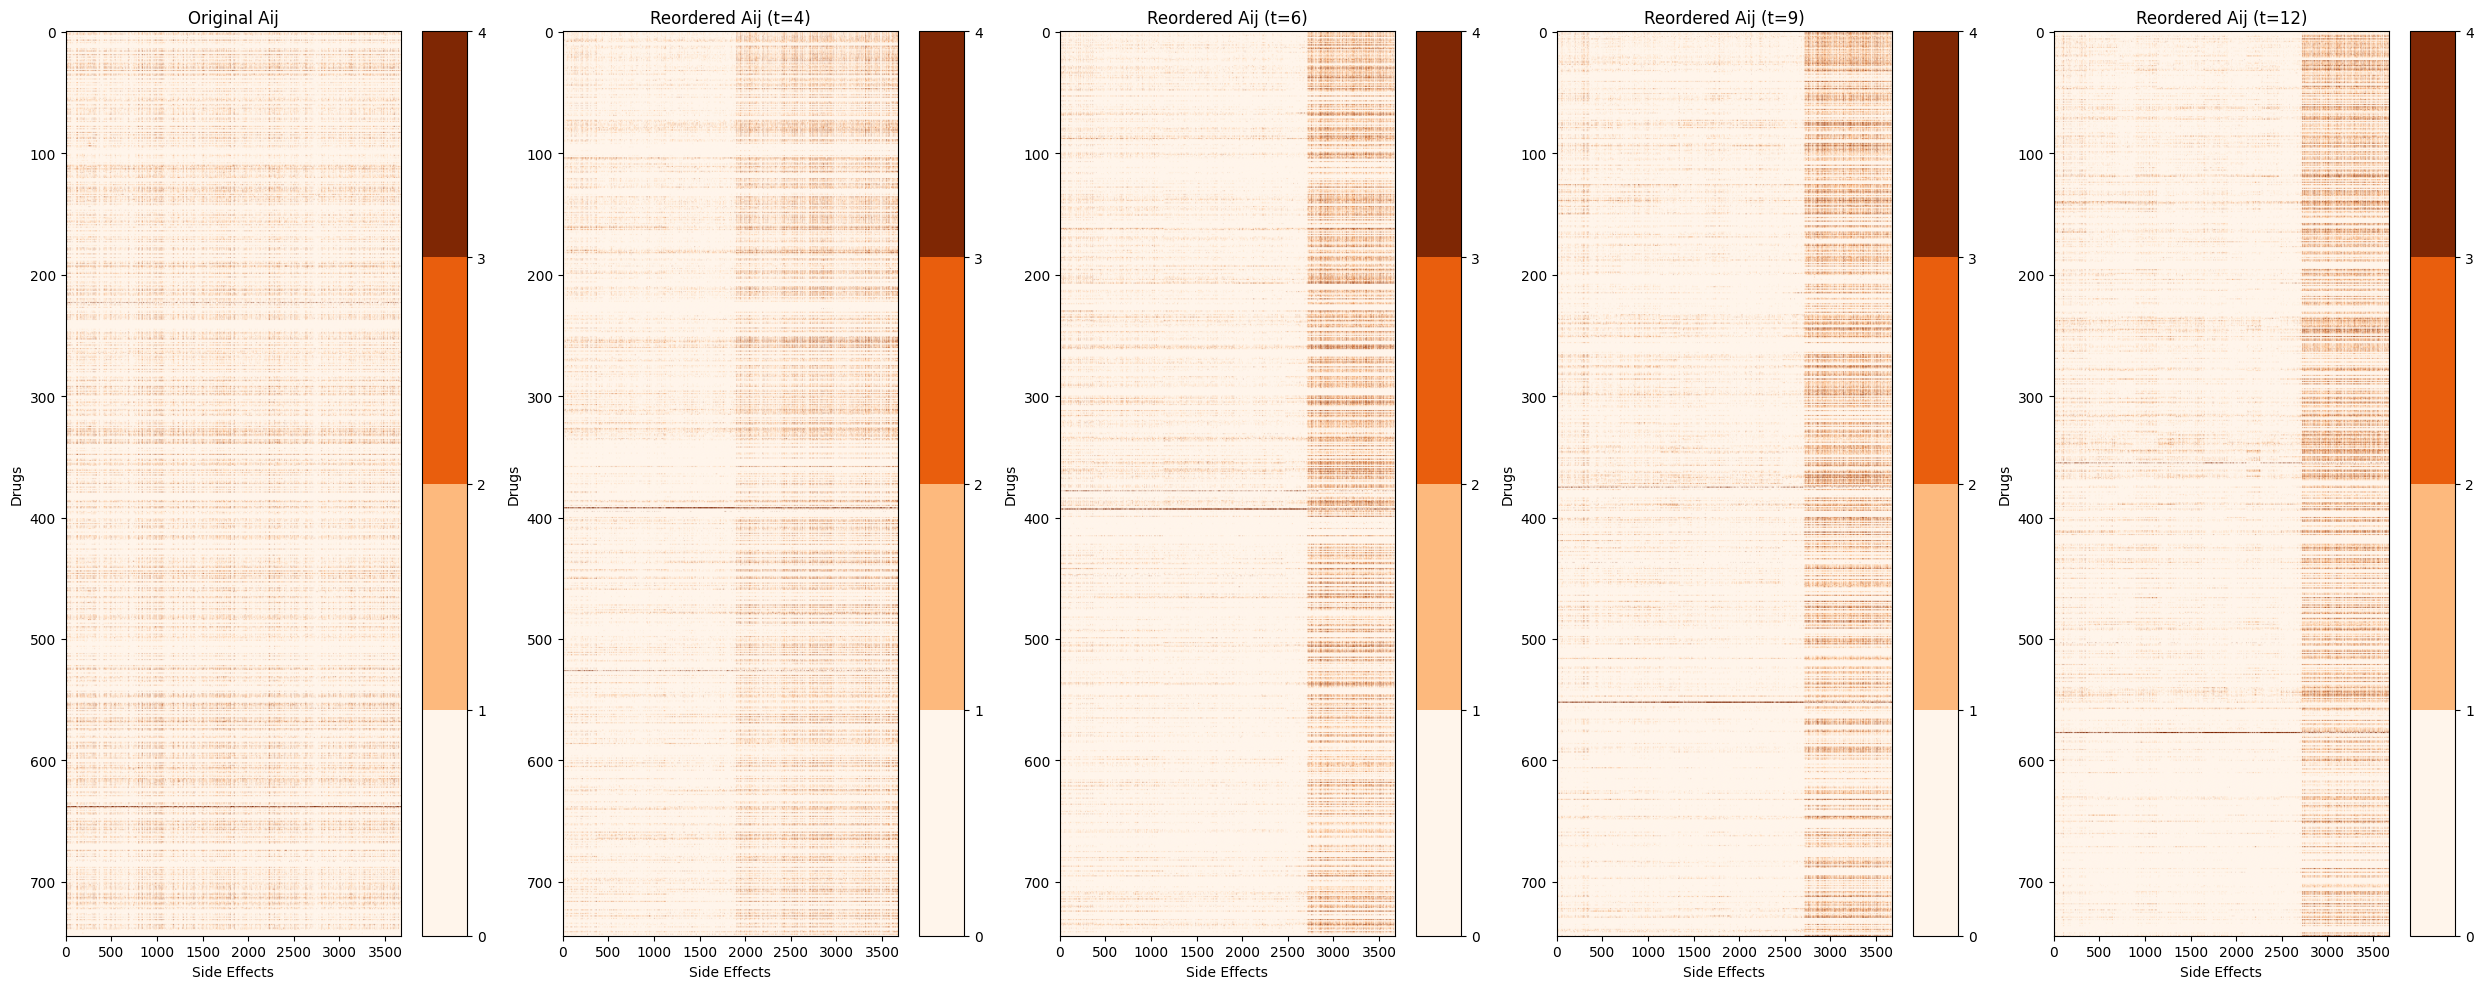

In [367]:
plots2.plot_reorder_Aij_multi()

Fix multidimensional scaling, det skal concat drug og effects. Skal også redegøres for i rapport

In [287]:
embedding_dim = 4
n_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.01
seed = 20
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train() 

In [288]:
links, ordinal_vals = model.predict_categories()
drug_emb, effect_emb = model.get_embeddings()

In [289]:
num_different = (Aij_real != links).sum().item()
ratio = num_different/(Aij_real.shape[0]*Aij_real.shape[1])
print(f"Number of differing entries: {num_different}, ratio: {ratio}")

Number of differing entries: 91214, ratio: 0.03329749777776966


In [293]:
plots2 = create_plots(links, Aij_real, drug_emb, effect_emb, dim_reduction="MDS", seed = 10)

In [294]:
plots2.links_space_both()

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_6085/2412149593.py:225: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_clusters +1)


TypeError: 'ListedColormap' object is not subscriptable